In [37]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
latent_dim = 3

#Build the encoder
encoder_inputs = keras.Input(shape=(88, 1))
x = layers.Conv1D(8, 3, activation='relu', padding='same', dilation_rate=2)(encoder_inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same', dilation_rate=2)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
encoder = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(encoder)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoder)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(88 * 8)(x)
x = layers.Reshape((88, 8))(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
decoded = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(x)
decoded = layers.Cropping1D(cropping=(0, 264))(decoded)
decoder = keras.Model(latent_inputs, decoded, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum((data - reconstruction) ** 2, axis=(1, 2))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + 0.35 * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


    def test_step(self, data):
        x = data

        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstructed_x = self.decoder(z, training=False)

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum((x - reconstructed_x) ** 2, axis=(1, 2))
        )

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + 0.35 * kl_loss

        results = {m.name: m.result() for m in self.metrics}
        results["reconstruction_loss"] = reconstruction_loss
        results["kl_loss"] = kl_loss
        results["total_loss"] = total_loss
        return results


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 88, 1)]      0           []                               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 88, 8)        32          ['input_5[0][0]']                
                                                                                                  
 max_pooling1d_4 (MaxPooling1D)  (None, 44, 8)       0           ['conv1d_10[0][0]']              
                                                                                                  
 conv1d_11 (Conv1D)             (None, 44, 16)       400         ['max_pooling1d_4[0][0]']        
                                                                                            

In [38]:
from sklearn.preprocessing import MinMaxScaler

features = pd.read_csv('features.csv')
labels = pd.read_csv('labels.csv')
(x_train, x_test, y_train, y_test) = train_test_split(
                                    features, labels, test_size=0.2, random_state=42)

x_train_seq = x_train.values[:, 0]
x_test_seq = x_test.values[:, 0]

x_train_features = x_train.values[:, 1:]
x_test_features = x_test.values[:, 1:]

scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train_features)
x_test = scaler.transform(x_test_features)

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

In [39]:
#learn_rate = [0.005, 0.01, 0.05, 0.1]
#batch_size = [32, 64, 128, 256]
learn_rate = [0.05, 0.1]
batch_size = [32, 64]

param_grid = dict(learn_rate=learn_rate, batch_size=batch_size)

best_score = None
best_params = {}

for lr in learn_rate:
    for bs in batch_size:
        
        vae = VAE(encoder, decoder)
        vae.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))

        vae.fit(x_train, batch_size=bs, epochs=3)

        score = vae.evaluate(x_test)

        if best_score is None or score < best_score:
            best_score = score
            best_params = {'learn_rate': lr, 'batch_size': bs}

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

lr = best_params['learn_rate']
bs = best_params['batch_size']

Epoch 1/3
262/262 [==============================] - 3s 6ms/step - loss: 3.0043 - reconstruction_loss: 1.3378 - kl_loss: 0.6545
Epoch 2/3
262/262 [==============================] - 1s 6ms/step - loss: 1.0964 - reconstruction_loss: 1.1000 - kl_loss: 3.0494e-04
Epoch 3/3
66/66 [==============================] - 0s 2ms/step - total_loss: 1.0650 - reconstruction_loss: 1.0650 - kl_loss: 1.3411e-06
Epoch 1/3
131/131 [==============================] - 3s 9ms/step - loss: 1.1430 - reconstruction_loss: 1.0916 - kl_loss: 0.0038
Epoch 2/3
131/131 [==============================] - 1s 9ms/step - loss: 1.0771 - reconstruction_loss: 1.0552 - kl_loss: 2.7582e-04
Epoch 3/3
66/66 [==============================] - 0s 3ms/step - total_loss: 0.9708 - reconstruction_loss: 0.9708 - kl_loss: 8.2761e-05
Epoch 1/3
262/262 [==============================] - 3s 5ms/step - loss: 1.4548 - reconstruction_loss: 1.3291 - kl_loss: 0.0020
Epoch 2/3
262/262 [==============================] - 1s 5ms/step - loss: 1.2743 

In [40]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = lr))

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True)

vae.fit(x_train, batch_size=bs, epochs=50, validation_data=(x_test,),
        callbacks=[reduce_lr, early_stop])

Epoch 1/50
131/131 [==============================] - 3s 11ms/step - loss: 1.4982 - reconstruction_loss: 1.4863 - kl_loss: 1.3350e-04 - val_total_loss: 1.4946 - val_reconstruction_loss: 1.4946 - val_kl_loss: 0.0000e+00 - lr: 0.0500
Epoch 2/50
131/131 [==============================] - 1s 9ms/step - loss: 1.4667 - reconstruction_loss: 1.4714 - kl_loss: 7.5706e-05 - val_total_loss: 1.4912 - val_reconstruction_loss: 1.4911 - val_kl_loss: 7.4536e-05 - lr: 0.0500
Epoch 3/50
131/131 [==============================] - 1s 9ms/step - loss: 1.4851 - reconstruction_loss: 1.4708 - kl_loss: 3.9416e-06 - val_total_loss: 1.4793 - val_reconstruction_loss: 1.4793 - val_kl_loss: 0.0000e+00 - lr: 0.0500
Epoch 4/50
131/131 [==============================] - 1s 9ms/step - loss: 1.4633 - reconstruction_loss: 1.4682 - kl_loss: 0.0000e+00 - val_total_loss: 1.4819 - val_reconstruction_loss: 1.4819 - val_kl_loss: 0.0000e+00 - lr: 0.0500
Epoch 5/50
131/131 [==============================] - 1s 9ms/step - loss: 1

In [41]:
import matplotlib.pyplot as plt

_, _, z_input = encoder.predict(x_train)
reconstructed_z_input = vae.decoder.predict(z_input)
_, _, reconstructed_z_encoded = vae.encoder.predict(reconstructed_z_input)

_, _, z_test_input = encoder.predict(x_test)
reconstructed_z_test_input = vae.decoder.predict(z_test_input)
_, _, reconstructed_z_test_encoded = vae.encoder.predict(reconstructed_z_test_input)

66/66 [==============================] - 0s 961us/step


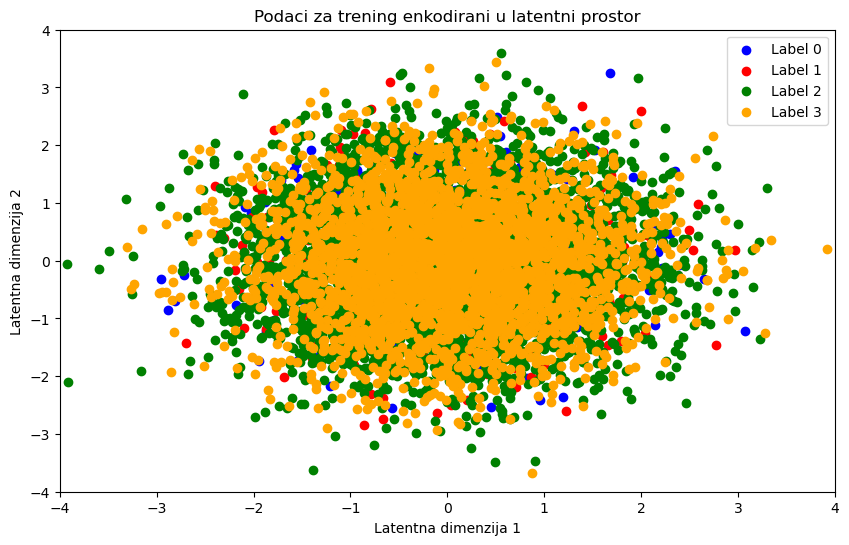

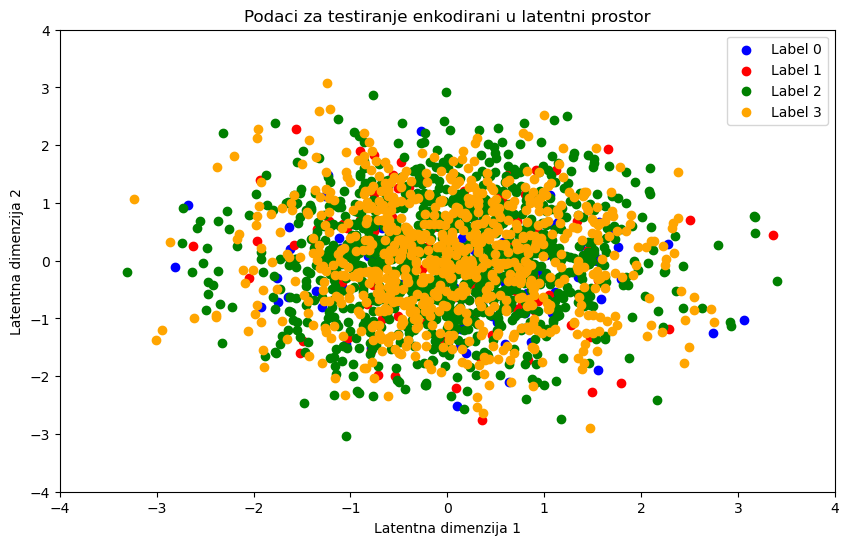

In [42]:
def plot_input_data(x_data, y_data):
    z_input = x_data
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=f'Label {label}')
    
    ax = plt.gca()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4]) 
    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()
    
plt.figure(figsize=(10, 6))
plt.title("Podaci za trening enkodirani u latentni prostor")
plot_input_data(z_input, y_train)

plt.figure(figsize=(10, 6))
plt.title("Podaci za testiranje enkodirani u latentni prostor")
plot_input_data(z_test_input, y_test)

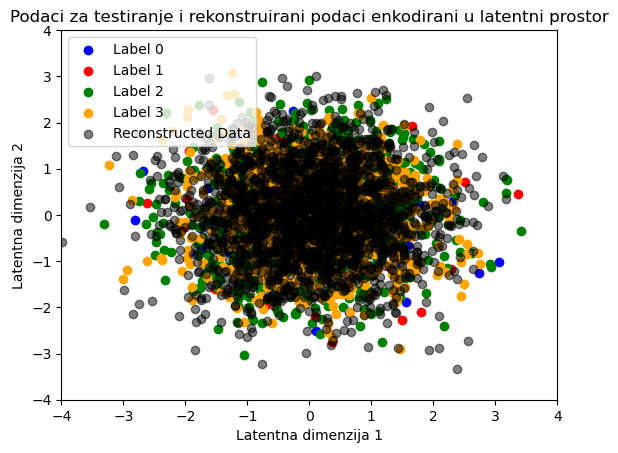

In [43]:
def plot_input_and_reconstructed_data(x_input_data, x_reconstructed, y_input_data):
    z_input = x_input_data
    recon_data_lsp = x_reconstructed
    
    unique_labels = np.unique(y_input_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_input_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=f'Label {label}')

    plt.scatter(recon_data_lsp[:, 0], recon_data_lsp[:, 1], c='black', alpha=0.5, label='Reconstructed Data')
    
    ax = plt.gca()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4]) 
    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.title("Podaci za testiranje i rekonstruirani podaci enkodirani u latentni prostor")
    plt.legend()
    plt.show()

plot_input_and_reconstructed_data(z_test_input, reconstructed_z_test_encoded, y_test)


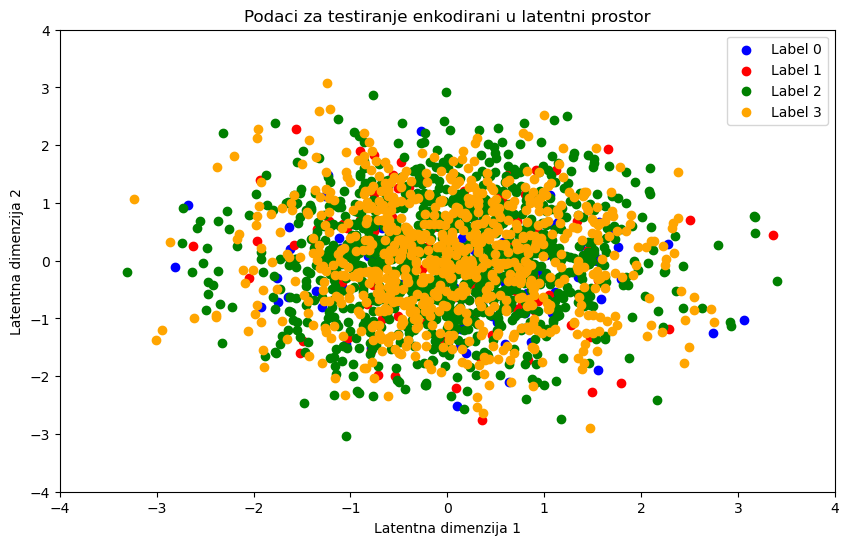

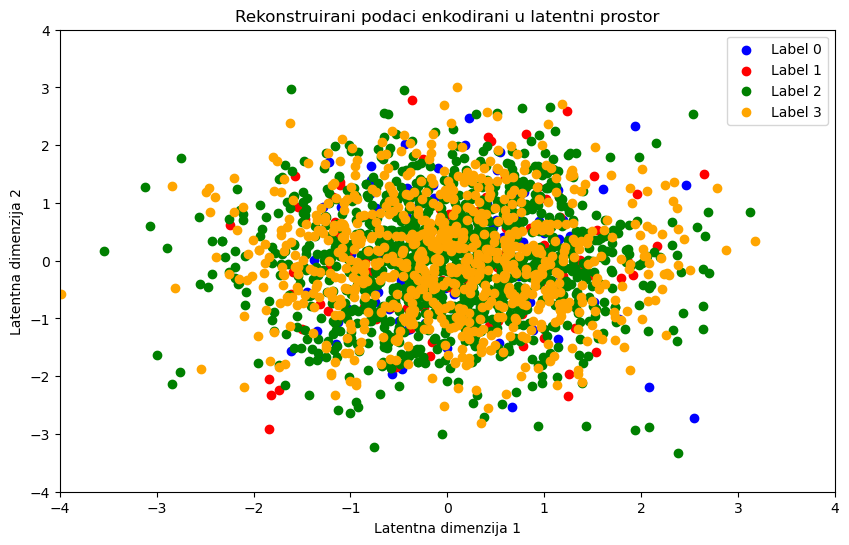

In [44]:
def plot_reconstructed_data(x_reconstructed, y_data):
    recon_data_lsp = x_reconstructed
    
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(recon_data_lsp[indices, 0], recon_data_lsp[indices, 1], 
                    c=label_colors[label], label=f'Label {label}')
    
    ax = plt.gca()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4]) 
    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()
    
plt.figure(figsize=(10, 6))
plt.title("Podaci za testiranje enkodirani u latentni prostor")
plot_input_data(z_test_input, y_test)

plt.figure(figsize=(10, 6))
plt.title("Rekonstruirani podaci enkodirani u latentni prostor")
plot_reconstructed_data(reconstructed_z_test_encoded, y_test)

1/1 [==============================] - 0s 16ms/step


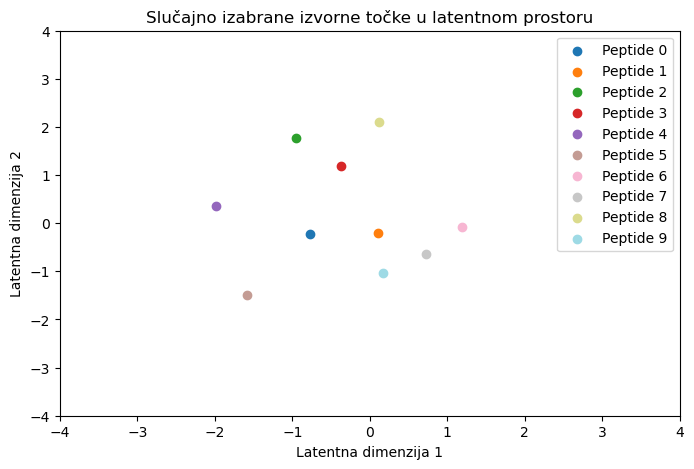

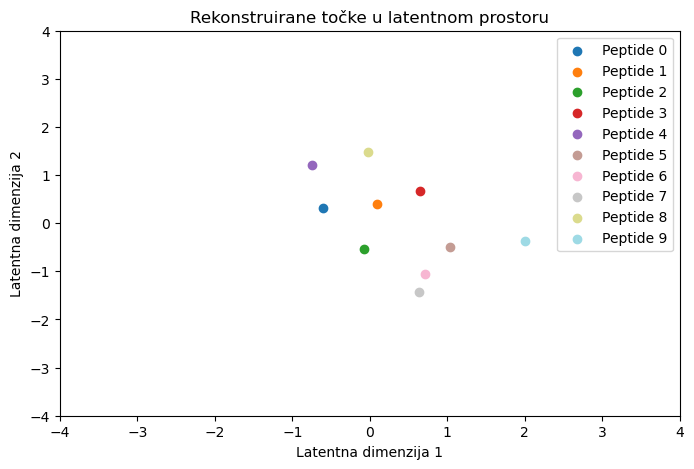

Udaljenost između svake pojedine točke i njoj pripadajuće rekonstruirane točke: 
 [0.79238546, 1.1195529, 2.5429826, 1.6353093, 1.8212016, 2.8443274, 1.2604197, 1.611739, 2.6729922, 2.4774618] 

Prosječna udaljenost između izvornih i rekonstruiranih točaka:  1.8778373718261718


In [45]:
selected_indices = np.random.choice(len(x_test), 10, replace=False)

selected_peptides = x_test[selected_indices]

_, _, encoded_selected_peptides = vae.encoder.predict(selected_peptides)
reconstructed_peptides = vae.decoder.predict(encoded_selected_peptides)
_, _, encoded_reconstructed_peptides = vae.encoder.predict(reconstructed_peptides)


def plot_selected_data(x_data):
    z_input = x_data
    num_peptides = z_input.shape[0]
    unique_colors = plt.cm.tab20(np.linspace(0, 1, num_peptides))

    for i in range(num_peptides):
        plt.scatter(z_input[i, 0], z_input[i, 1], color=unique_colors[i], label=f'Peptide {i}')

    ax = plt.gca()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])     
    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.xlim=()
    plt.show()

    
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y)**2))


plt.figure(figsize=(8, 5))
plt.title("Slučajno izabrane izvorne točke u latentnom prostoru")
plot_selected_data(encoded_selected_peptides)

plt.figure(figsize=(8, 5))
plt.title("Rekonstruirane točke u latentnom prostoru")
plot_selected_data(encoded_reconstructed_peptides)


distances = []

for i in range(10):
    dist = euclidean_distance(encoded_selected_peptides[i], encoded_reconstructed_peptides[i])
        
    distances.append(dist)

print("Udaljenost između svake pojedine točke i njoj pripadajuće rekonstruirane točke: \n", distances, "\n")
print("Prosječna udaljenost između izvornih i rekonstruiranih točaka: ", np.sum(distances)/10)

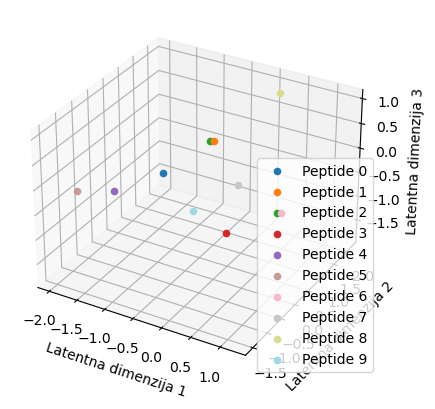

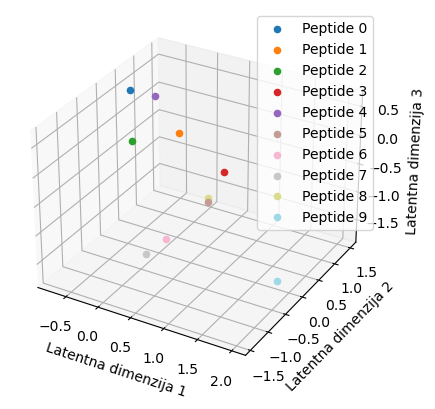

Udaljenost između svake pojedine točke i njoj pripadajuće rekonstruirane točke: 
 [0.79238546, 1.1195529, 2.5429826, 1.6353093, 1.8212016, 2.8443274, 1.2604197, 1.611739, 2.6729922, 2.4774618] 

Prosječna udaljenost između izvornih i rekonstruiranih točaka:  1.8778374


In [46]:
def plot_selected_data_3D(x_data):
    z_input = x_data
    num_peptides = z_input.shape[0]
    unique_colors = plt.cm.tab20(np.linspace(0, 1, num_peptides))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i in range(num_peptides):
        ax.scatter(z_input[i, 0], z_input[i, 1], z_input[i, 2], color=unique_colors[i], label=f'Peptide {i}')
    
    ax.set_xlabel("Latentna dimenzija 1")
    ax.set_ylabel("Latentna dimenzija 2")
    ax.set_zlabel("Latentna dimenzija 3")
    plt.legend()
    plt.show()

plot_selected_data_3D(encoded_selected_peptides)

plot_selected_data_3D(encoded_reconstructed_peptides)

distances = []

for i in range(10):
    dist = euclidean_distance(encoded_selected_peptides[i], encoded_reconstructed_peptides[i])
    distances.append(dist)

print("Udaljenost između svake pojedine točke i njoj pripadajuće rekonstruirane točke: \n", distances, "\n")
print("Prosječna udaljenost između izvornih i rekonstruiranih točaka: ", np.mean(distances))


In [47]:
from Bio import pairwise2
from Bio.Seq import Seq

def calculate_sequence_similarity(seq1, seq2):
  
    seq1 = Seq(seq1)
    seq2 = Seq(seq2)

    alignments = pairwise2.align.globalxx(seq1, seq2)

    best_alignment = alignments[0]
    seq1_aligned, seq2_aligned, score, begin, end = best_alignment

    similarity = (score / max(len(seq1), len(seq2)))

    return similarity

similarities_train = []
similarities_test = []

for i in range(50):
    row_similarities_train = []
    row_similarities_test = []
    for j in range(50,101):
        sim_train = calculate_sequence_similarity(x_train_seq[i], x_train_seq[j])
        sim_test = calculate_sequence_similarity(x_test_seq[i], x_test_seq[j])
        row_similarities_train.append(sim_train)
        row_similarities_test.append(sim_test)
        
    similarities_train.append(row_similarities_train)
    similarities_test.append(row_similarities_test)
    
similarities_train = np.array(similarities_train)
similarities_test = np.array(similarities_test)

print(similarities_train)
print(similarities_test)

[[0.25581395 0.13953488 0.39534884 ... 0.39534884 0.18604651 0.34883721]
 [0.1025641  0.         0.12820513 ... 0.13157895 0.125      0.05263158]
 [0.20512821 0.28       0.23076923 ... 0.18421053 0.32       0.23684211]
 ...
 [0.33333333 0.21621622 0.35897436 ... 0.34210526 0.32432432 0.34210526]
 [0.33333333 0.17777778 0.26666667 ... 0.33333333 0.22222222 0.33333333]
 [0.07692308 0.25       0.15384615 ... 0.18421053 0.16666667 0.23684211]]
[[0.27272727 0.18604651 0.27906977 ... 0.27906977 0.20930233 0.30232558]
 [0.36363636 0.25581395 0.27906977 ... 0.3255814  0.1627907  0.18604651]
 [0.25       0.17241379 0.26666667 ... 0.14285714 0.3        0.2       ]
 ...
 [0.15909091 0.31034483 0.33333333 ... 0.26190476 0.28571429 0.14285714]
 [0.34090909 0.2972973  0.54054054 ... 0.28571429 0.24324324 0.2972973 ]
 [0.09090909 0.13793103 0.06666667 ... 0.0952381  0.17647059 0.2       ]]


In [48]:
distances_train = []
distances_test = []

for i in range(50):
    row_distances_train = []
    row_distances_test = []
    for j in range(50,101):
        dist_train = euclidean_distance(z_input[i], z_input[j])
        dist_test = euclidean_distance(z_test_input[i], z_test_input[j])
        row_distances_train.append(dist_train)
        row_distances_test.append(dist_test)
        
    distances_train.append(row_distances_train)
    distances_test.append(row_distances_test)
        
distances_train = np.array(distances_train)
distances_test = np.array(distances_test)

normalized_distances_train = scaler.fit_transform(distances_train)
normalized_distances_test = scaler.fit_transform(distances_test)

print(normalized_distances_train)
print(normalized_distances_test)

[[0.         0.39384392 0.49747676 ... 0.35689873 0.41860235 0.1411334 ]
 [0.20828572 0.4824988  0.64063805 ... 0.41462868 0.5847007  0.04469816]
 [0.97083443 0.02066365 0.4632213  ... 0.18191251 0.7379895  0.79786706]
 ...
 [0.51855904 0.7371241  0.56691045 ... 0.7663369  0.38207525 0.6394596 ]
 [0.39321905 0.24576694 0.54185015 ... 0.23740712 0.5673447  0.26807788]
 [0.7411423  0.8247925  1.         ... 0.7018055  1.         0.30112645]]
[[0.2931149  0.23216689 0.33435026 ... 0.18316701 0.35358578 0.30103728]
 [0.72572494 0.20243943 0.5932847  ... 0.4830171  0.6904577  0.6815922 ]
 [0.5013951  0.16276675 0.47694227 ... 0.17611846 0.5635905  0.5400793 ]
 ...
 [0.85047793 0.49700654 0.670565   ... 0.39182603 0.8064126  0.84630096]
 [0.8553382  1.         0.28992298 ... 1.         0.11829302 0.41891247]
 [0.79547155 0.6954118  0.06954259 ... 0.6002333  0.37719023 0.5131988 ]]


In [49]:
from scipy.stats import spearmanr, kendalltau, pearsonr

correlation_train, p_value_train = spearmanr(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = spearmanr(similarities_test.flatten(), distances_test.flatten())

print("Spearmanov koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test, "\n")

correlation_train, p_value_train = pearsonr(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = pearsonr(similarities_test.flatten(), distances_test.flatten())

print("Pearsonov koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test, "\n")

correlation_train, p_value_train = kendalltau(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = kendalltau(similarities_test.flatten(), distances_test.flatten())

print("Kendall tau koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test)

Spearmanov koeficijent korelacije za skupove podataka za trening i testiranje: 
 0.08728368459838667 -0.009970639211215073
p-value: 1.0153674913528269e-05 0.614782720898662 

Pearsonov koeficijent korelacije za skupove podataka za trening i testiranje: 
 0.08482361056556839 -0.01936332689468905
p-value: 1.794683725796231e-05 0.32836508276153464 

Kendall tau koeficijent korelacije za skupove podataka za trening i testiranje: 
 0.0588682381698766 -0.006849288720888107
p-value: 9.056115019436466e-06 0.6058414862702075


In [50]:
print(z_input[111])
#print(x_train[0])
print(reconstructed_z_input[0])

[1.381082  0.9647313 1.1686525]
[[0.462329  ]
 [0.462329  ]
 [0.462329  ]
 [0.6137055 ]
 [0.4665617 ]
 [0.57090676]
 [0.65457284]
 [0.4654735 ]
 [0.4654735 ]
 [0.4654735 ]
 [0.4654735 ]
 [0.4654735 ]
 [0.4654735 ]
 [0.48859584]
 [0.5492385 ]
 [0.462329  ]
 [0.462329  ]
 [0.462329  ]
 [0.462329  ]
 [0.462329  ]
 [0.462329  ]
 [0.462329  ]
 [0.462329  ]
 [0.462329  ]
 [0.462329  ]
 [0.462329  ]
 [0.462329  ]
 [0.6904587 ]
 [0.528844  ]
 [0.45802268]
 [0.6267865 ]
 [0.462329  ]
 [0.462329  ]
 [0.462329  ]
 [0.462329  ]
 [0.462329  ]
 [0.462329  ]
 [0.462329  ]
 [0.462329  ]
 [0.5512312 ]
 [0.46478724]
 [0.5390366 ]
 [0.62321013]
 [0.54380685]
 [0.4645806 ]
 [0.53261095]
 [0.6102165 ]
 [0.462329  ]
 [0.462329  ]
 [0.43938178]
 [0.38062632]
 [0.4654735 ]
 [0.4654735 ]
 [0.4654735 ]
 [0.4654735 ]
 [0.4654735 ]
 [0.4654735 ]
 [0.31820816]
 [0.3335894 ]
 [0.4291782 ]
 [0.47202694]
 [0.462329  ]
 [0.462329  ]
 [0.57254124]
 [0.4932315 ]
 [0.4373974 ]
 [0.45620057]
 [0.4654735 ]
 [0.4654735 ]
 [